In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

columns = ['total duration','load duration', 'prompt eval count', 'prompt eval duration','prompt eval rate','eval count','eval duration','eval rate']
rows = []
current_row = []
with open('/Users/adam/Downloads/text1.txt', 'r') as file:
    for line in file:
        pattern = r"\s(\d+m)?(\d+(\.?\d+)?)"
        result = re.search(pattern, line)
        if not result:
            continue
        result = result.groups()
        if result[0] != None:
            minutes = int(result[0][:-1])
            seconds = float(result[1])
            current_row.append(minutes*60 + seconds)
        else:
            current_row.append(result[1])
        if len(current_row) == len(columns):
            rows.append(current_row)
            current_row = []

df = pd.DataFrame(rows, columns=columns)
print(df)

   total duration load duration prompt eval count prompt eval duration  \
0     4.175484246     36.669776                16            86.158192   
1      2.83066848     37.467608                38           708.925162   
2    21.202907893     38.496037                40           746.302332   
3      7.47741603     37.168773                32           670.896921   
4    12.162052326     56.497719                24            480.22984   
5    19.461214432     37.572201                22           438.898331   
6    46.403514532     36.547454                21           419.589603   
7     4.436162761     36.550354                19           362.823836   
8     5.436755418     39.982107                26           541.881371   
9    21.359703119      36.13002                16           305.271101   
10   16.076264637     40.088017                50          1.113888368   
11    6.850157987     38.549176                15           277.685682   
12     107.414877     36.549063       

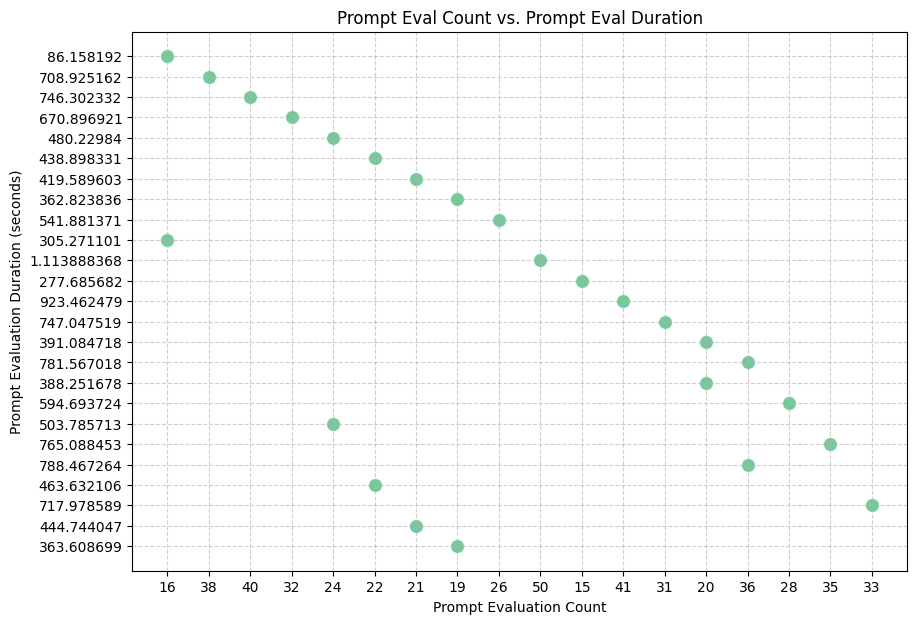

TypeError: 'value' must be an instance of str or bytes, not a float

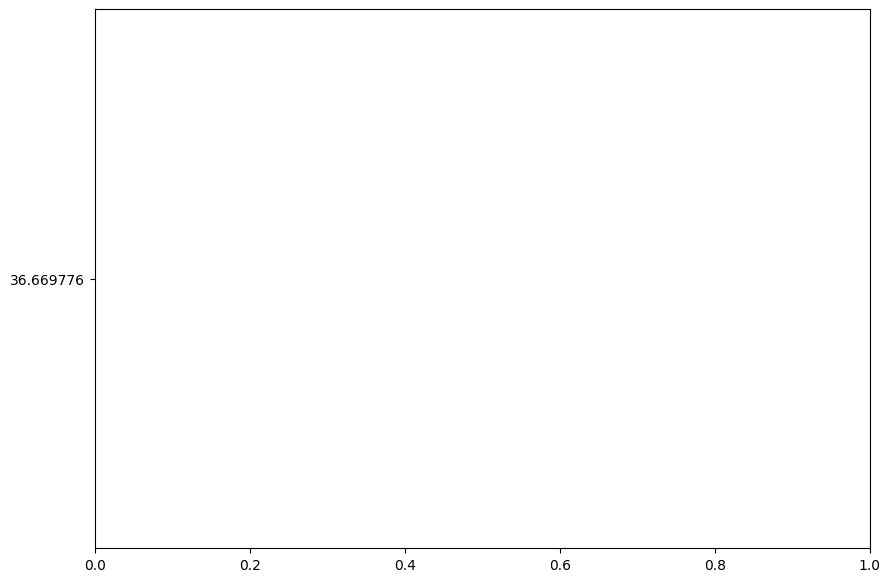

In [4]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='prompt eval count', y='prompt eval duration', data=df, s=100, alpha=0.7, color='mediumseagreen')
plt.title('Prompt Eval Count vs. Prompt Eval Duration')
plt.xlabel('Prompt Evaluation Count')
plt.ylabel('Prompt Evaluation Duration (seconds)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Scatter plot: total duration vs. load duration ---
plt.figure(figsize=(10, 7))
sns.scatterplot(x='total duration', y='load duration', data=df, s=100, alpha=0.7, color='darkorange')
plt.title('Total Duration vs. Load Duration')
plt.xlabel('Total Duration (seconds)')
plt.ylabel('Load Duration (seconds)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()